In [ ]:
import numpy
from numpy import *
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import norm
import seaborn as sns ; sns.set();
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Model parameters
N =  33938216.0
theta = 1185; alpha = 0.2504; tau = 0.0631; epsi = 1/5.2; omega = 1/15; Phi = 1/15; d = 0.0667; kappa = 0.5; b = 0.7621;
delta  = 0.034; phi = 0.0982; mu = 1/(75.6 * 365); sigma = 2.8213e-5; b = 0.7621 ; rho = 0.5314; beta_I = 1 ; eta =0.1255;
beta_A = 0.539; beta_H = 0.347; #N = np.mean(df_n);

In [ ]:
#  Initial Condition
S0, V10, V20, E0, A0, I0, H0, R0 =  [32556143,66 , 3, 70900, 35450, 3545, 30568, 3331]

# tspan
time = arange(0,1114)

# SVEAIHR model ASs Remark this is not useful

def SVEAIRH(t, y, params):

    S, V1, V2, E, A, I, H, R = y

    alpha, tau, epsi, omega, Phi, d, kappa, b,
    phi, sigma, b, rho, beta_I, eta, beta_A, beta_H = params

    lam = alpha * (beta_A * A + beta_I * I + beta_H * H)/ N
    dS = theta - lam * S - (mu+phi) * S + tau * V1
    dV1 = phi * S - (tau + sigma + mu) * V1
    dV2 = sigma * V1 - (eta + mu) * V2
    dE = lam * S - (epsi + mu) * E
    dA = epsi * (1-kappa) * E - (mu+Phi) * A
    dI = epsi * kappa * E + Phi * (1-rho) * A - (mu+delta+ omega)* I
    dH = omega * (1-b) * I -(mu+delta+ d) *H
    dR = omega * b * I  + Phi * rho * A + d* H + eta * V2 - mu * R
    return [dS, dV1, dV2, dE, dA, dI, dH, dR]

# Latin Hypercube Sampling

def lhs(n_samples, param_ranges):

    samples = zeros((n_samples, len(param_ranges)))
    for i, (low, high) in enumerate (param_ranges):
        samples[:, i] = random.uniform(low, high, n_samples)
    return samples

# Partial Rank Correlation Coefficient (PRCC)
def prcc(samples, outputs):
    n_samples, n_params = samples.shape
    prcc_values = zeros(n_params)
    for i in range(n_params):
        x = samples[:, i]
        y = outputs
        rx = x.argsort().argsort() / (n_samples - 1)
        ry = y.argsort().argsort() / (n_samples - 1)
        prcc_values[i] = corrcoef(rx, ry)[0, 1]
    return prcc_values

In [ ]:
# Sensitivity Analysis

p = [(0.1,0.3), (0.05, 0.07), (1/4.2,1/6.2), (1/14,1/16), (1/14,1/16), (0.05, 0.07), (0.4, 0.6), (0.002, 0.004),
                (0.08, 0.1),(1e-4, 3e-4) ,(0.6, 0.8), (0.4, 0.6), (0.8, 1), (0.09, 0.2), (0.4, 0.6), (0.2, 0.4)]
n_samples = 5000

# Generate samples using Latin Hypercube Sampling

samples = lhs (n_samples, p)

# Calculate RA, RI, RH for each samples

RA_list = [] ;  RI_list = []; RH_list = []

for i in range(n_samples):

    p = samples[i, :]

    S = theta * (p[1]+p[9]+mu)/(mu * p[1]+(p[9]+mu+mu+p[8]))
    V1 = theta * p[8] / (mu * p[1]+(p[9]+mu+mu+p[8]))
    V2 = theta * p[8] * p[9]/ ((p[13]+mu) * (mu * p[1]+(p[9]+mu+mu+p[8])))
    R = theta * p[8] * p[9] * p[13]/ (mu * ((p[13]+mu) * (mu * p[1]+(p[9]+mu+mu+p[8]))))
    N = theta/ mu
    k4 = p[2]+ mu; k5 = 1 - p[6]; k6 = mu + p[4]; k7 = 1 - p[11] ; k8 = mu + p[7]+ p[3]
    k9 = 1 - p[11]; k10 = mu + p[7] + p[5]

    RA = p[0] * S * p[14] * p[2] * k5 / (N *k4 * k6)
    RI = p[0] * S * p[12] * p[2] * (p[4]*k5*k7 + p[6]*k6)/ (N*k4*k6*k8)
    RH = p[0] * S * p[15] * p[2] * p[3] * k9 * (p[4]*k5*k7+ p[6]*k6)/ (N*k4*k6*k8*k10)

    RA_list.append(RA)
    RI_list.append(RI)
    RH_list.append(RH)


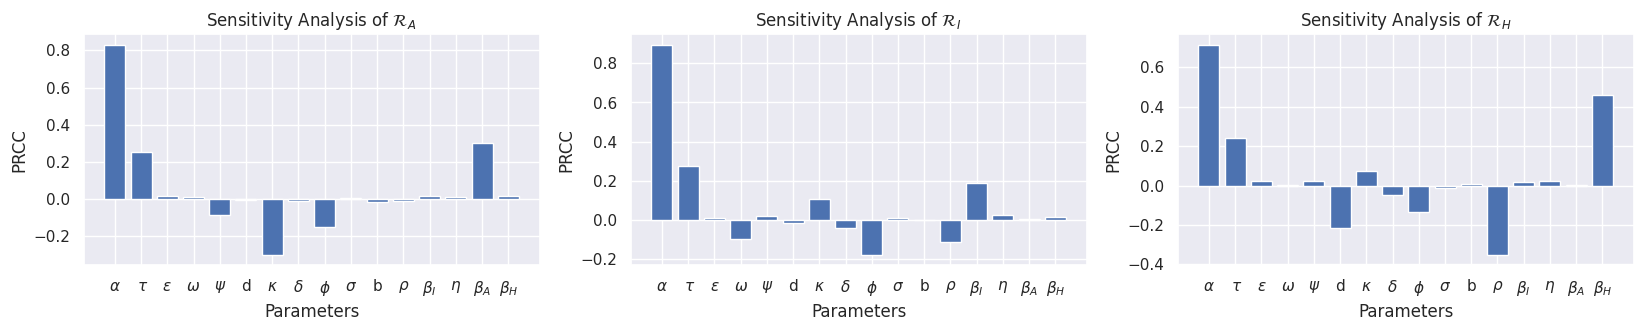

In [ ]:
# Convert RA_list, RI_list and RH_listto a numpy array

RA = array(RA_list)
RI = array(RI_list)
RH = array(RH_list)

# Calculate PRCC

prcc_A = prcc(samples, RA)
prcc_I = prcc(samples, RI)
prcc_H = prcc(samples, RH)

# Plot the PRCC Results

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3))
parm_name = ['$\\alpha$', ' $\\tau$', '$\\epsilon$', '$\\omega$','$\\psi$','d','$\\kappa$','$\\delta$',
             '$\\phi$','$\\sigma$','b','$\\rho$', '$\\beta_{I}$','$\\eta$','$\\beta_{A}$', '$\\beta_{H}$']
x = arange(len(parm_name))
ax1.bar(x,prcc_A)
ax1.set_xticks(x,parm_name); ax1.set_xlabel("Parameters"); ax1.set_ylabel("PRCC")
ax1.set_title("Sensitivity Analysis of $\\mathcal{R}_{A}$");

ax2.bar(x,prcc_I)
ax2.set_xticks(x,parm_name); ax2.set_xlabel("Parameters"); ax2.set_ylabel("PRCC")
ax2.set_title("Sensitivity Analysis of $\\mathcal{R}_{I}$");

ax3.bar(x,prcc_H)
ax3.set_xticks(x,parm_name); ax3.set_xlabel("Parameters"); ax3.set_ylabel("PRCC")
ax3.set_title("Sensitivity Analysis of $\\mathcal{R}_{H}$");